# Prepate notebook

In [1]:
%load_ext autoreload
%autoreload 2

In [16]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from plotting_utilities import *

# Load example data

In [3]:
data = pd.read_csv('data.csv', index_col = 0)

In [4]:
data.head()

,Title,Author,My Rating,Number of Pages,Year Published,Original Publication Year,Date Added,recommended,isbn,categories,description,publisher
0,"Gay New York: Gender, Urban Culture, and the M...",George Chauncey,4,496.0,1995.0,1994.0,2019-11-01,False,NaN,['History'],Shattering the myth that gay life only existed...,Basic Books
1,"The Source of Self-Regard: Selected Essays, Sp...",Toni Morrison,2,354.0,2019.0,2019.0,2019-06-15,False,9.780526e+12,['Literary Collections'],Arguably the most celebrated and revered write...,Knopf
4,Over the Top: A Raw Journey to Self-Love,Jonathan Van Ness,2,400.0,2019.0,2019.0,2019-10-26,False,9.780063e+12,['Biography & Autobiography'],A laugh-and-cry-out-loud memoir from the belov...,Harper
5,Never Enough: The Neuroscience and Experience ...,Judith Grisel,4,256.0,2019.0,2019.0,2019-10-25,False,9.780386e+12,['Biography & Autobiography'],From a renowned behavioral neuroscientist and ...,Doubleday Books
7,Hurricanes: A Memoir,Rick Ross,2,288.0,2019.0,2019.0,2019-10-24,False,9.781488e+12,['Biography & Autobiography'],*NEW YORK TIMES BESTSELLER* “A gripping journe...,Hanover Square Press


In [5]:
labels = pd.read_csv('labels.csv', index_col = 0)

In [6]:
labels = labels.reindex(labels.sum().sort_values(ascending = False).index.tolist(), axis=1)

In [7]:
labels.head()

,natural_sciences,history,culture,social_studies,biography_memoir,medicine,philosophy,literature_fiction,technology
0,False,True,False,True,False,False,False,False,False
1,False,False,True,True,False,False,False,False,False
4,False,False,False,True,True,False,False,False,False
5,True,False,False,False,False,True,False,False,False
7,False,False,True,False,True,False,False,False,False


In [8]:
labels.sum()

natural_sciences      305
history               223
culture               169
social_studies        163
biography_memoir      153
medicine              146
philosophy            128
literature_fiction     77
technology             23
dtype: int64

In [10]:
data = data.join(labels)

# Display distributions of continuous variable, split by secondary field

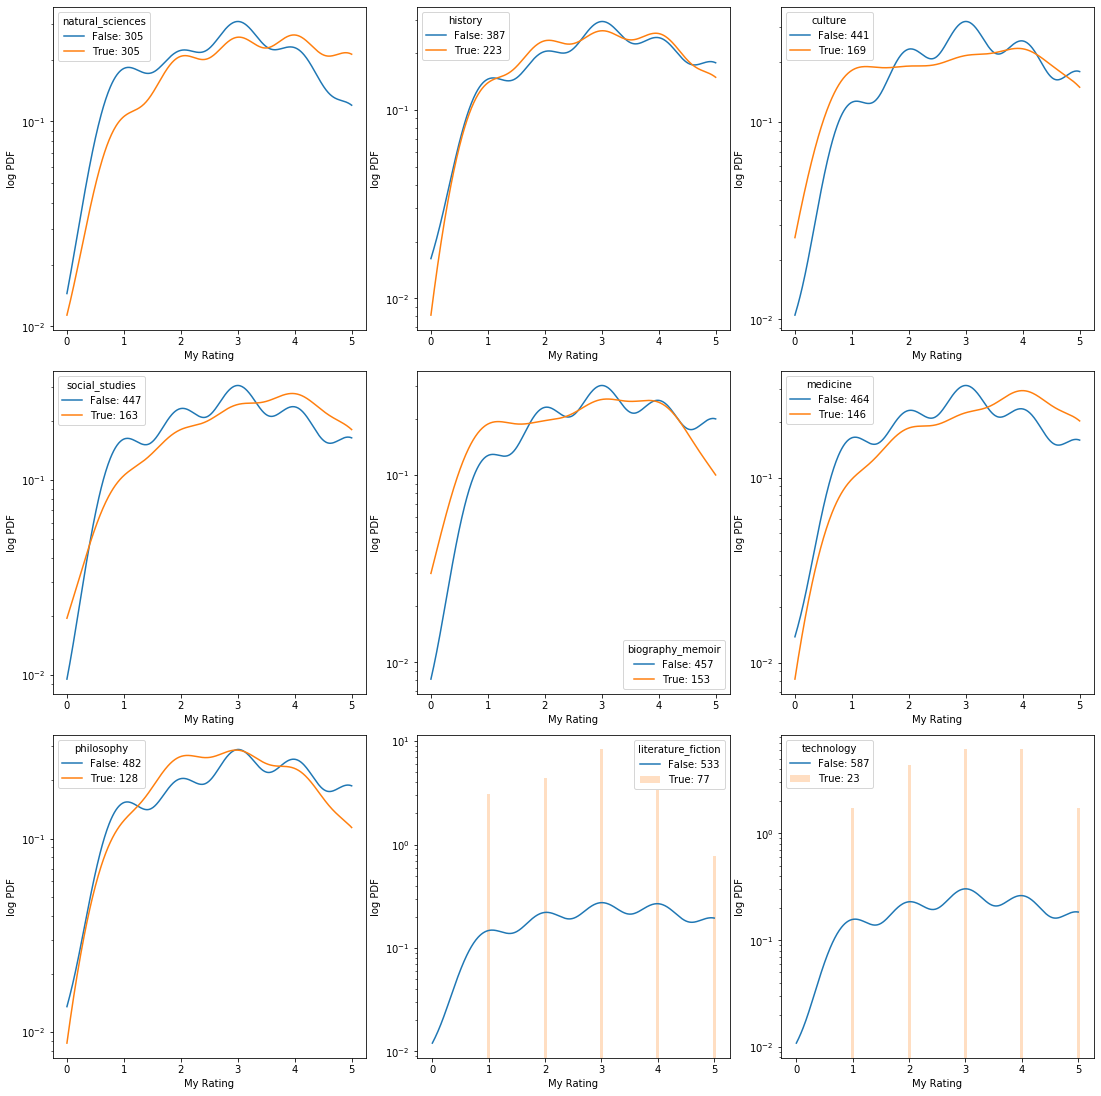

In [11]:
features = labels.columns.tolist()
value_col = 'My Rating'

fig, ax = feature_distributions(data, features, value_col)

# Display distributions of continuous variable, split by secondary field  with highlighted categorizations

In [12]:
data['primary_label'] = labels.idxmax(axis=1)
data['general_category'] = data['literature_fiction'].apply(lambda v: 'fiction' if v else 'nonfiction')

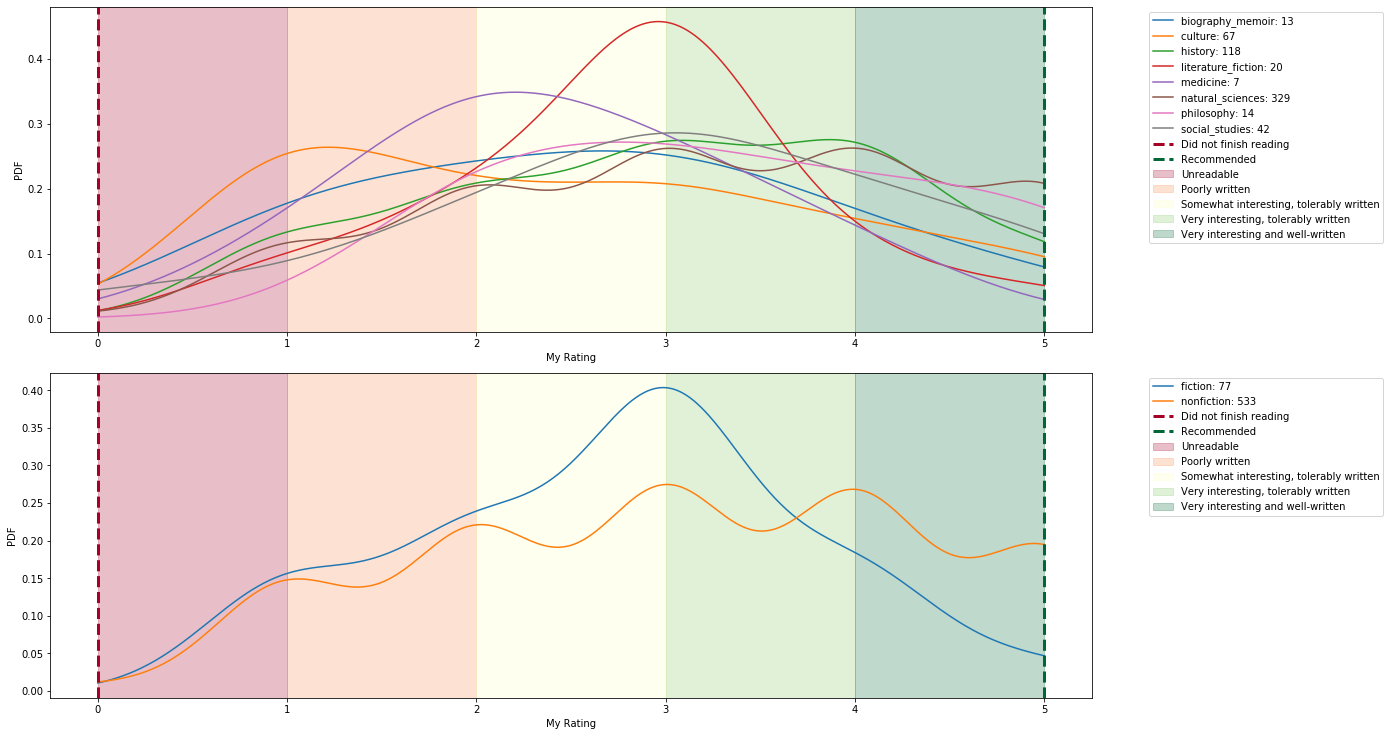

In [13]:
features = ['primary_label', 'general_category']
value_col = 'My Rating'
cmap = matplotlib.cm.get_cmap('RdYlGn')
colors = [cmap(i) for i in np.linspace(0, 1, 5)]

highlighting = [(0, 1, colors[0], 'Unreadable'),
                (1, 2, colors[1], 'Poorly written'),
                (2, 3, colors[2], 'Somewhat interesting, tolerably written'),
                (3, 4, colors[3], 'Very interesting, tolerably written'),
                (4, 5, colors[4], 'Very interesting and well-written')]

edge_values = [(0, colors[0], 'Did not finish reading'),
               (5, colors[4], 'Recommended')]

fig, ax = feature_distributions(data, features, value_col, 
                                ncols = 1, w_scale = 15,
                                min_group_size = 5, log_y = False,
                                highlighting = highlighting, edge_values = edge_values, 
                                anchor_legend = (1.05, 1))

# Display joint plot of continuous variable distributions

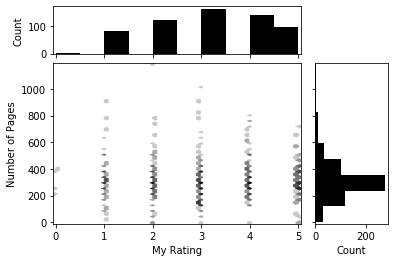

In [42]:
fig, ax_joint, ax_marg_x, ax_marg_y = jointplot(data['My Rating'], data['Number of Pages'])

# Display joint plot of continuous variable distributions, with range highlighting

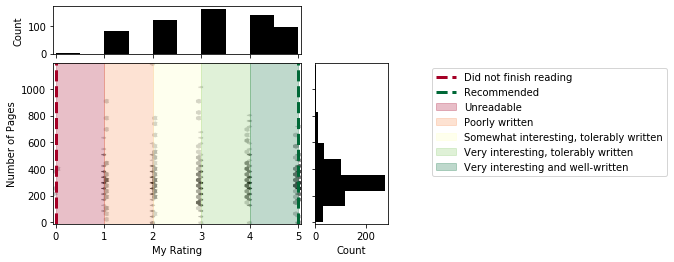

In [40]:
highlighting = [(0, 1, colors[0], 'Unreadable'),
                (1, 2, colors[1], 'Poorly written'),
                (2, 3, colors[2], 'Somewhat interesting, tolerably written'),
                (3, 4, colors[3], 'Very interesting, tolerably written'),
                (4, 5, colors[4], 'Very interesting and well-written')]

edge_values = [(0, colors[0], 'Did not finish reading'),
               (5, colors[4], 'Recommended')]

fig, ax_joint, ax_marg_x, ax_marg_y = jointplot(data['My Rating'], data['Number of Pages'],
                                                highlighting = highlighting, edge_values = edge_values, 
                                                anchor_legend = (2.5, 1) 
                                                )

# Display joint plot of continuous variable distributions, split by category

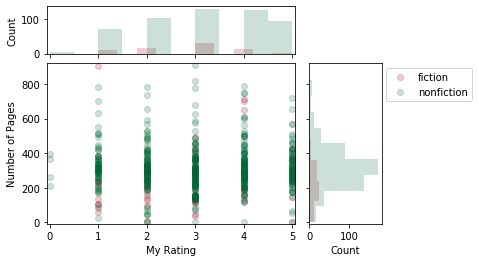

In [57]:
grouped_data = data.groupby('general_category')

cmap = matplotlib.cm.get_cmap('RdYlGn')
colors = [cmap(i) for i in np.linspace(0, 1, len(grouped_data))]


fig = None

ic = 0
for name, group in grouped_data:
    if fig is None:
        fig, ax_joint, ax_marg_x, ax_marg_y = jointplot(group['My Rating'], group['Number of Pages'],
                                                        joint_type = 'scatter', scatter_label = name, 
                                                        c = colors[ic])
        ic += 1
    else:
        jointplot(group['My Rating'], group['Number of Pages'], joint_type = 'scatter', scatter_label = name, 
                  fig_axes = (fig, ax_joint, ax_marg_x, ax_marg_y), c = colors[ic],
                  anchor_legend = (1.35, 1))
        ic += 1